In [1]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

plt.style.use('fivethirtyeight')

In [2]:
# Load the data
train_data = pd.read_csv('train.csv')
stores_data = pd.read_csv('stores.csv')
features_data = pd.read_csv('features.csv')

print("Train Data Shape:", train_data.shape)
print("Stores Data Shape:", stores_data.shape)
print("Features Data Shape:", features_data.shape)

print("\nFirst few rows of Train Data:")
print(train_data.head())

print("\nFirst few rows of Stores Data:")
print(stores_data.head())

print("\nFirst few rows of Features Data:")
print(features_data.head())

Train Data Shape: (421570, 5)
Stores Data Shape: (45, 3)
Features Data Shape: (8190, 12)

First few rows of Train Data:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

First few rows of Stores Data:
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

First few rows of Features Data:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-

In [3]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
features_data['Date'] = pd.to_datetime(features_data['Date'])

merged_data = pd.merge(train_data, features_data, on=['Store', 'Date'], how='left')
merged_data = pd.merge(merged_data, stores_data, on=['Store'], how='left')

print("\nMissing values in merged dataset:")
print(merged_data.isnull().sum())

print("\nMerged dataset shape:", merged_data.shape)
print("\nFirst few rows of merged dataset:")
print(merged_data.head())


Missing values in merged dataset:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64

Merged dataset shape: (421570, 17)

First few rows of merged dataset:
   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   

In [4]:
# Handle missing values
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in merged_data.columns:
        merged_data[col].fillna(0, inplace=True)


if 'CPI' in merged_data.columns:
    merged_data['CPI'].fillna(method='ffill', inplace=True)
    merged_data['CPI'].fillna(method='bfill', inplace=True)

if 'Unemployment' in merged_data.columns:
    merged_data['Unemployment'].fillna(method='ffill', inplace=True)
    merged_data['Unemployment'].fillna(method='bfill', inplace=True)

print("\nMissing values: ")
print(merged_data.isnull().sum())

merged_data['Year'] = merged_data['Date'].dt.year
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Week'] = merged_data['Date'].dt.isocalendar().week
merged_data['Day'] = merged_data['Date'].dt.day

if 'IsHoliday_y' in merged_data.columns:
    merged_data['IsHoliday'] = merged_data['IsHoliday_y'].astype(int)
    print("Using IsHoliday_y")
elif 'IsHoliday_x' in merged_data.columns:
    merged_data['IsHoliday'] = merged_data['IsHoliday_x'].astype(int)
    print("Using IsHoliday_x")
else:
    merged_data['IsHoliday'] = 0
    #IsHoliday column created with default value 0

print("\nDataset after preprocessing:")
print(merged_data.head())
print("\nColumns available:", merged_data.columns.tolist())


Missing values: 
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
dtype: int64
Using IsHoliday_y

Dataset after preprocessing:
   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...         CPI  Unemployment  \
0        0.0        0.0        0.0  ...  211.096358        

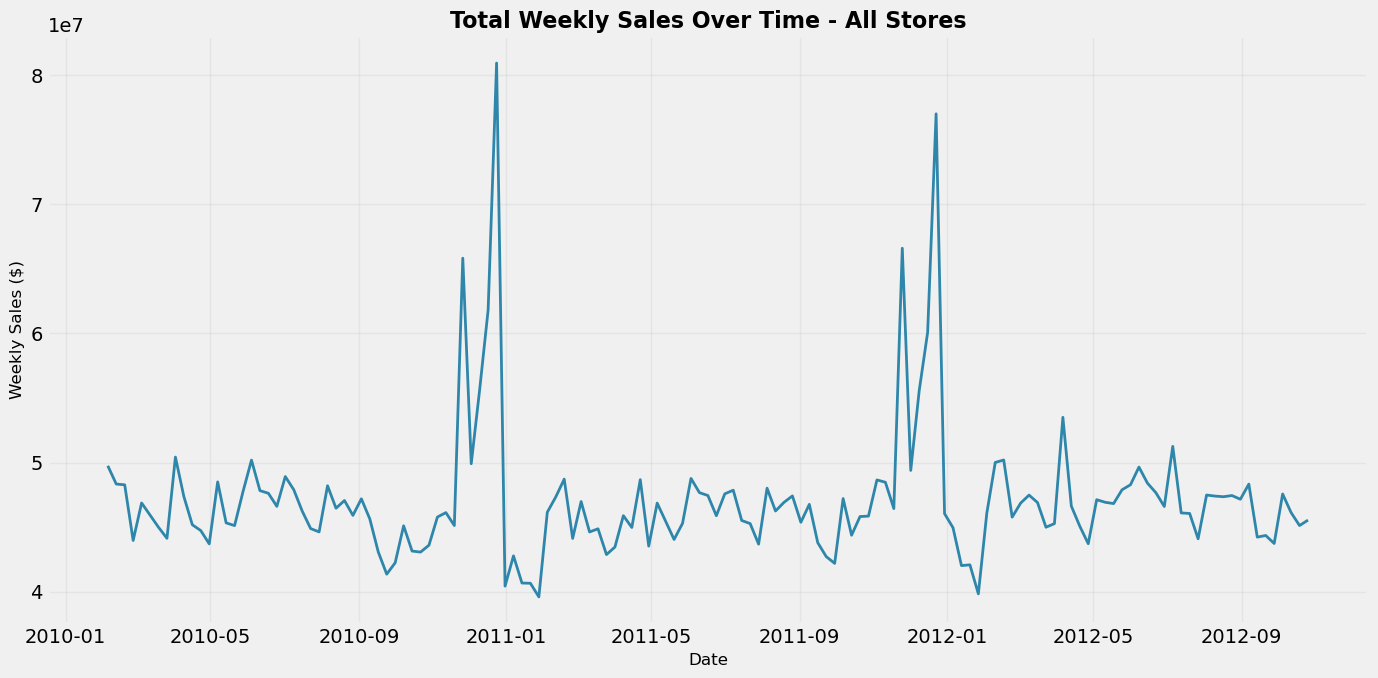

Total sales across all stores: $6,737,218,987
Peak sales week: $80,931,416
Average weekly sales: $47,113,419


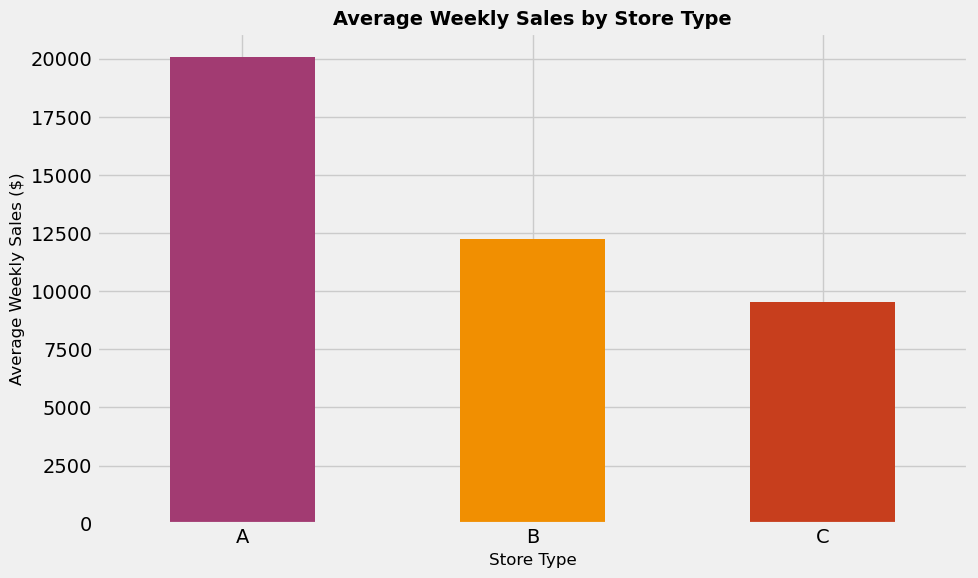

Store Type Performance:
   • Type A: $20,100 average weekly sales
   • Type B: $12,237 average weekly sales
   • Type C: $9,520 average weekly sales


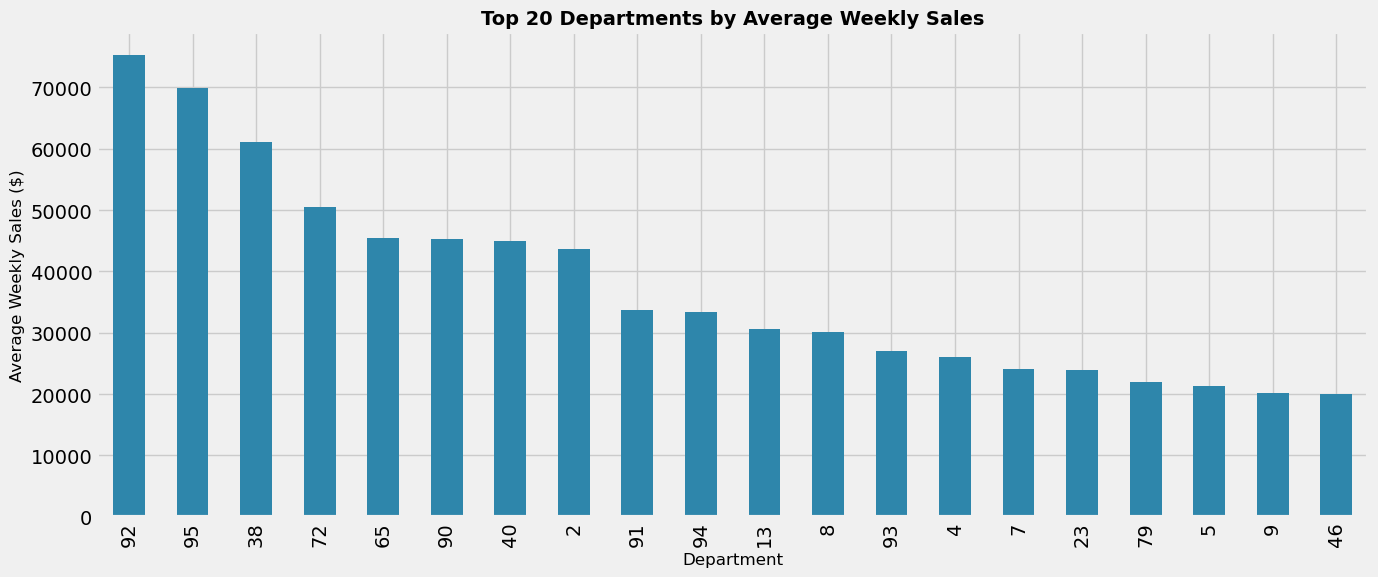

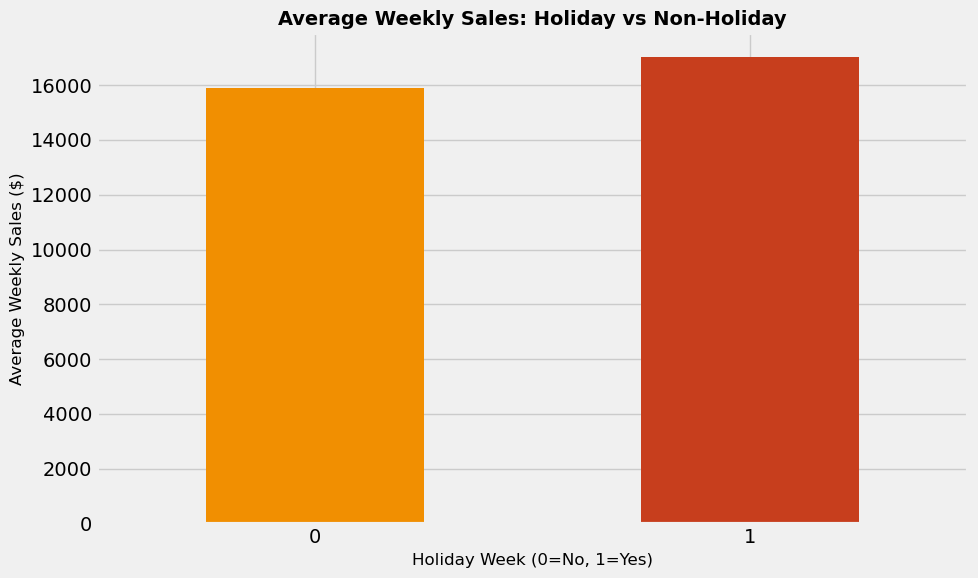

Holiday sales boost: +7.1%


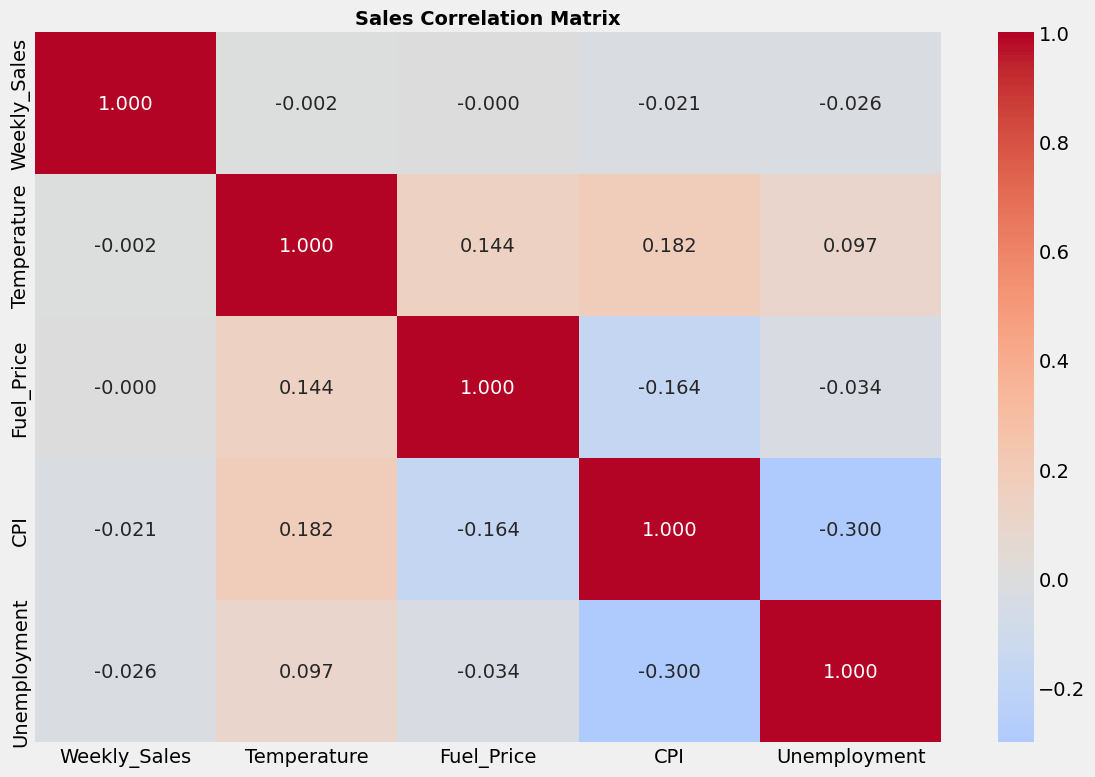

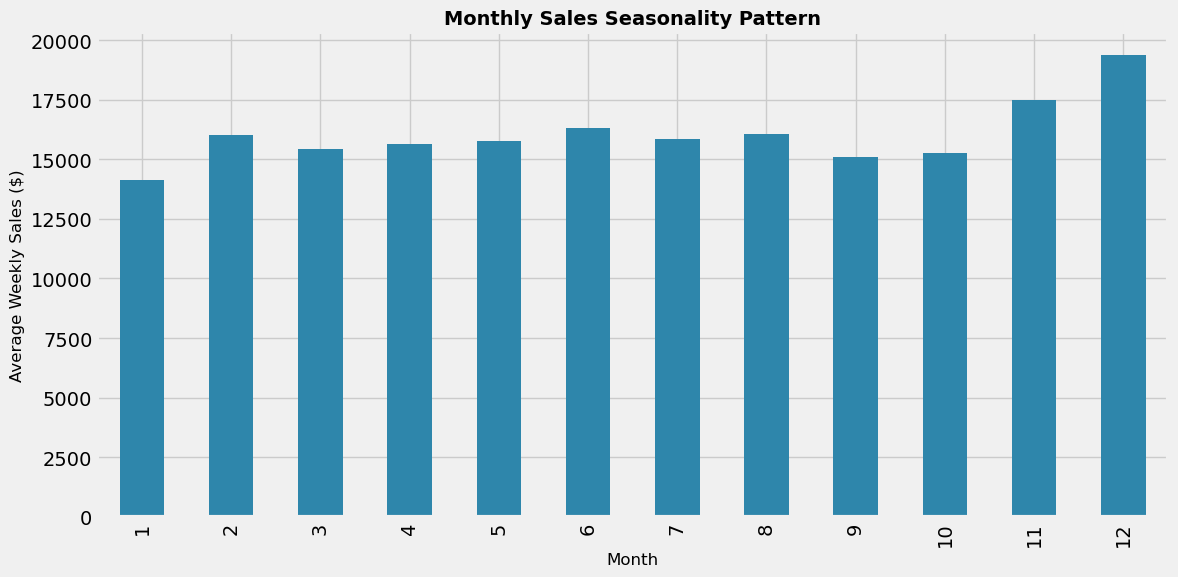

Best sales month: 12 ($19,356)
Worst sales month: 1 ($14,126)


In [5]:
#Overall sales trend
plt.figure(figsize=(14, 7))
weekly_sales = merged_data.groupby('Date')['Weekly_Sales'].sum()
plt.plot(weekly_sales.index, weekly_sales.values, linewidth=2, color='#2E86AB')
plt.title('Total Weekly Sales Over Time - All Stores', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total sales across all stores: ${weekly_sales.sum():,.0f}")
print(f"Peak sales week: ${weekly_sales.max():,.0f}")
print(f"Average weekly sales: ${weekly_sales.mean():,.0f}")

# Sales by store type
plt.figure(figsize=(10, 6))
store_type_sales = merged_data.groupby('Type')['Weekly_Sales'].mean()
colors = ['#A23B72', '#F18F01', '#C73E1D']
store_type_sales.plot(kind='bar', color=colors)
plt.title('Average Weekly Sales by Store Type', fontsize=14, fontweight='bold')
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Average Weekly Sales ($)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Store Type Performance:")
for store_type, sales in store_type_sales.items():
    print(f"   • Type {store_type}: ${sales:,.0f} average weekly sales")

#Top departments
plt.figure(figsize=(14, 6))
dept_sales = merged_data.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)
dept_sales.head(20).plot(kind='bar', color='#2E86AB')
plt.title('Top 20 Departments by Average Weekly Sales', fontsize=14, fontweight='bold')
plt.xlabel('Department', fontsize=12)
plt.ylabel('Average Weekly Sales ($)', fontsize=12)
plt.tight_layout()
plt.show()

#Holiday impact visualization
plt.figure(figsize=(10, 6))
holiday_sales = merged_data.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_sales.plot(kind='bar', color=['#F18F01', '#C73E1D'])
plt.title('Average Weekly Sales: Holiday vs Non-Holiday', fontsize=14, fontweight='bold')
plt.xlabel('Holiday Week (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Average Weekly Sales ($)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

holiday_boost = ((holiday_sales[1] - holiday_sales[0]) / holiday_sales[0]) * 100
print(f"Holiday sales boost: {holiday_boost:+.1f}%")

#Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
numeric_cols = [col for col in numeric_cols if col in merged_data.columns]
correlation_matrix = merged_data[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Sales Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Monthly seasonality
plt.figure(figsize=(12, 6))
monthly_sales = merged_data.groupby('Month')['Weekly_Sales'].mean()
monthly_sales.plot(kind='bar', color='#2E86AB')
plt.title('Monthly Sales Seasonality Pattern', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Weekly Sales ($)', fontsize=12)
plt.tight_layout()
plt.show()

best_month = monthly_sales.idxmax()
worst_month = monthly_sales.idxmin()
print(f"Best sales month: {best_month} (${monthly_sales[best_month]:,.0f})")
print(f"Worst sales month: {worst_month} (${monthly_sales[worst_month]:,.0f})")

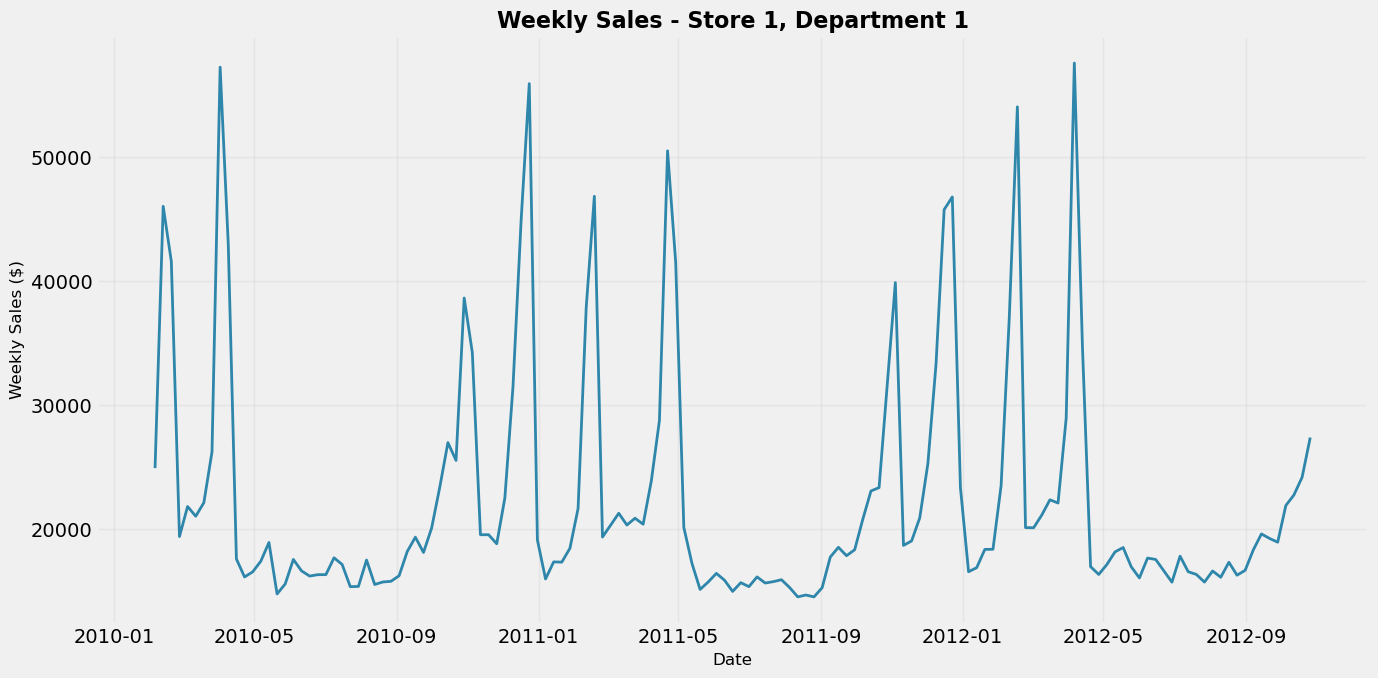

Train data size: 114
Test data size: 29
Training period: 2010-02-05 00:00:00 to 2012-04-06 00:00:00
Testing period: 2012-04-13 00:00:00 to 2012-10-26 00:00:00


In [6]:
# sample id for department and store
store_id = 1
dept_id = 1

store_dept_data = merged_data[(merged_data['Store'] == store_id) & (merged_data['Dept'] == dept_id)]
store_dept_data = store_dept_data.sort_values('Date')

store_dept_data.set_index('Date', inplace=True)

ts_data = store_dept_data['Weekly_Sales']

plt.figure(figsize=(14, 7))
plt.plot(ts_data, linewidth=2, color='#2E86AB')
plt.title(f'Weekly Sales - Store {store_id}, Department {dept_id}', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

train_size = int(len(ts_data) * 0.8)
train_data_ts = ts_data[:train_size]
test_data_ts = ts_data[train_size:]

print(f"Train data size: {len(train_data_ts)}")
print(f"Test data size: {len(test_data_ts)}")
print(f"Training period: {train_data_ts.index.min()} to {train_data_ts.index.max()}")
print(f"Testing period: {test_data_ts.index.min()} to {test_data_ts.index.max()}")

C:\Users\27733\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\27733\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\27733\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1190.659
Date:                Wed, 08 Oct 2025   AIC                           2387.317
Time:                        23:55:29   BIC                           2395.500
Sample:                    02-05-2010   HQIC                          2390.638
                         - 04-06-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5879      0.056     10.537      0.000       0.479       0.697
ma.L1         -0.9999      0.087    -11.542      0.000      -1.170      -0.830
sigma2      8.079e+07   1.08e-09   7.46e+16      0.0

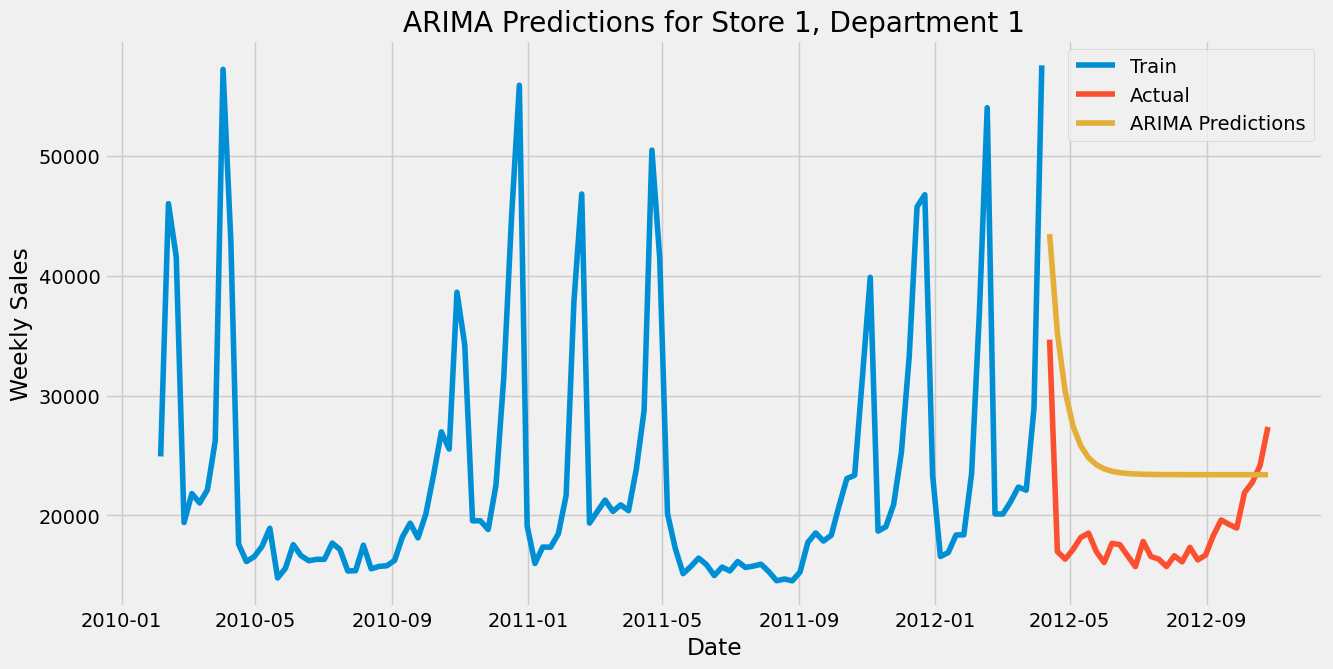

In [7]:
arima_model = ARIMA(train_data_ts, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

arima_predictions = arima_model_fit.forecast(steps=len(test_data_ts))

arima_rmse = np.sqrt(mean_squared_error(test_data_ts, arima_predictions))
arima_mae = mean_absolute_error(test_data_ts, arima_predictions)
arima_mape = mean_absolute_percentage_error(test_data_ts, arima_predictions)

print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"ARIMA MAE: {arima_mae:.2f}")
print(f"ARIMA MAPE: {arima_mape*100:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(train_data_ts.index, train_data_ts, label='Train')
plt.plot(test_data_ts.index, test_data_ts, label='Actual')
plt.plot(test_data_ts.index, arima_predictions, label='ARIMA Predictions')
plt.title(f'ARIMA Predictions for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\27733\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\27733\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1083.248
Date:                            Wed, 08 Oct 2025   AIC                           2176.496
Time:                                    23:55:33   BIC                           2189.571
Sample:                                02-05-2010   HQIC                          2181.789
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6121      0.512     -1.195      0.232      -1.616       0.392
ma.L1          0.7861      0.379   

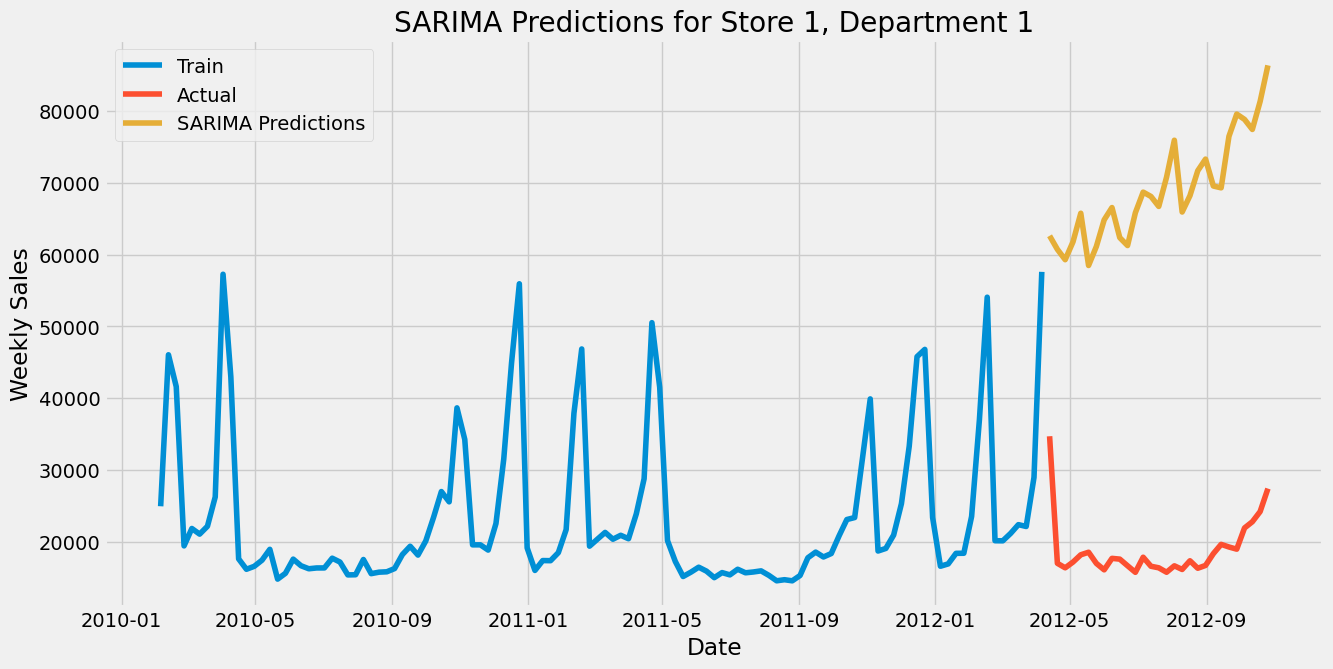

In [8]:
sarima_model = SARIMAX(train_data_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=False)

print(sarima_model_fit.summary())

sarima_predictions = sarima_model_fit.forecast(steps=len(test_data_ts))

sarima_rmse = np.sqrt(mean_squared_error(test_data_ts, sarima_predictions))
sarima_mae = mean_absolute_error(test_data_ts, sarima_predictions)
sarima_mape = mean_absolute_percentage_error(test_data_ts, sarima_predictions)

print(f"SARIMA RMSE: {sarima_rmse:.2f}")
print(f"SARIMA MAE: {sarima_mae:.2f}")
print(f"SARIMA MAPE: {sarima_mape*100:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(train_data_ts.index, train_data_ts, label='Train')
plt.plot(test_data_ts.index, test_data_ts, label='Actual')
plt.plot(test_data_ts.index, sarima_predictions, label='SARIMA Predictions')
plt.title(f'SARIMA Predictions for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

23:55:37 - cmdstanpy - INFO - Chain [1] start processing
23:55:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 5813.86
Prophet MAE: 3746.15
Prophet MAPE: 21.02%


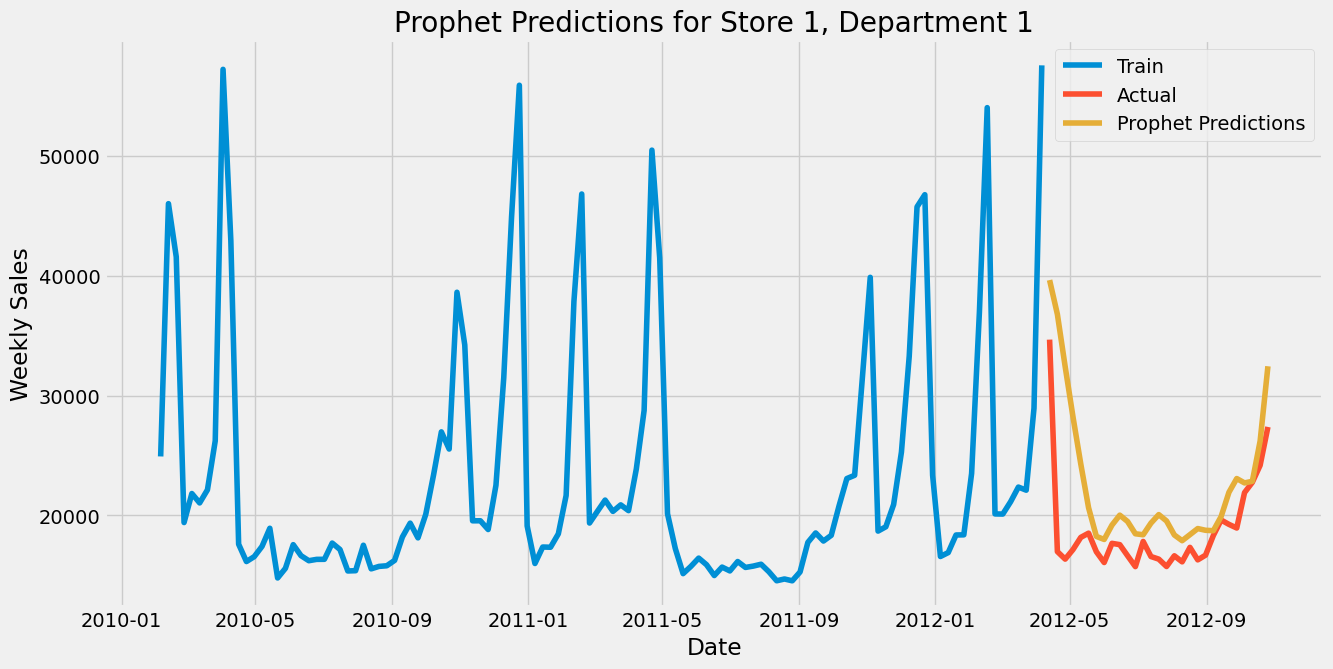

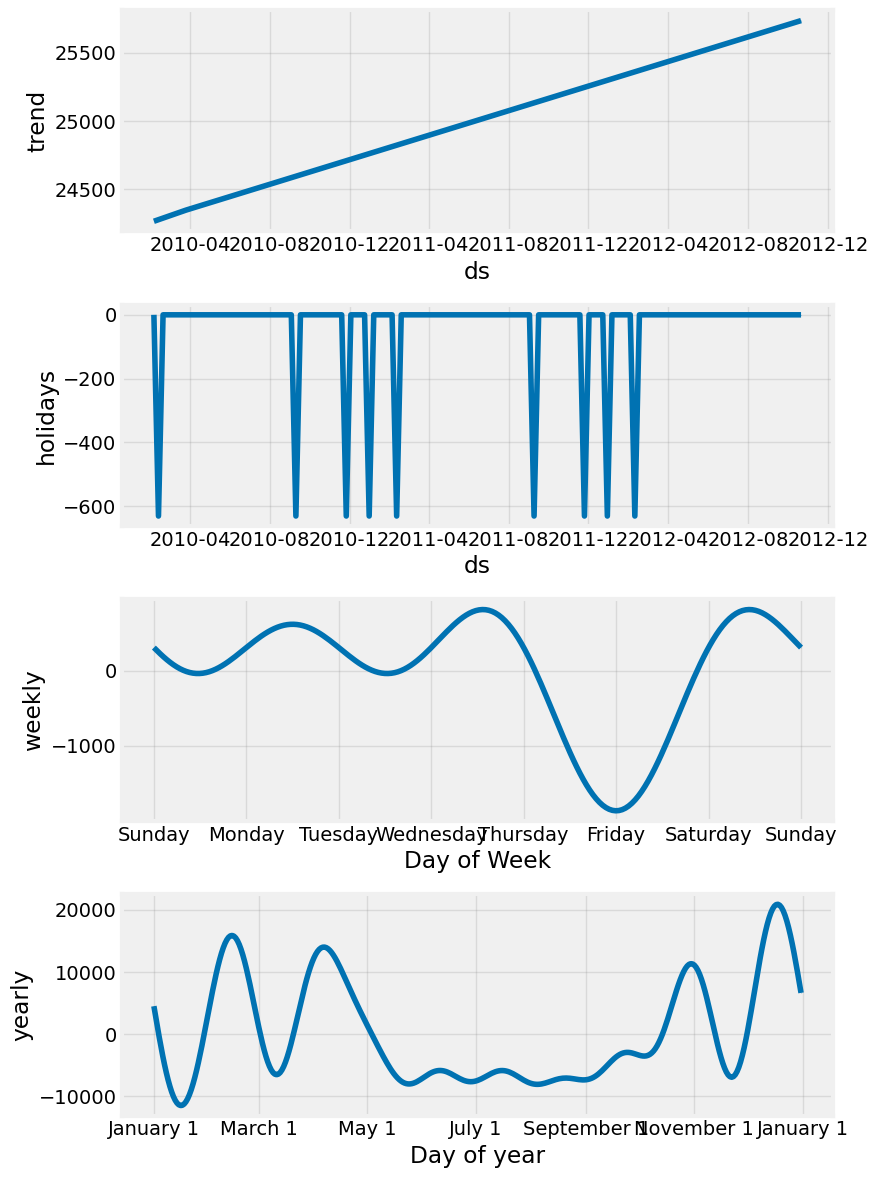

In [9]:
prophet_data = store_dept_data.reset_index()[['Date', 'Weekly_Sales']]
prophet_data.columns = ['ds', 'y']

# Create holidays dataframe for Prophet
holidays_df = store_dept_data[store_dept_data['IsHoliday'] == 1].reset_index()[['Date']]
holidays_df.columns = ['ds']
holidays_df['holiday'] = 'store_holiday'

prophet_train = prophet_data.iloc[:train_size]
prophet_test = prophet_data.iloc[train_size:]

prophet_model = Prophet(holidays=holidays_df, yearly_seasonality=True, weekly_seasonality=True)
prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='W')
prophet_forecast = prophet_model.predict(future)

prophet_predictions = prophet_forecast.iloc[train_size:]['yhat'].values

prophet_rmse = np.sqrt(mean_squared_error(test_data_ts, prophet_predictions))
prophet_mae = mean_absolute_error(test_data_ts, prophet_predictions)
prophet_mape = mean_absolute_percentage_error(test_data_ts, prophet_predictions)

print(f"Prophet RMSE: {prophet_rmse:.2f}")
print(f"Prophet MAE: {prophet_mae:.2f}")
print(f"Prophet MAPE: {prophet_mape*100:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(prophet_train['ds'], prophet_train['y'], label='Train')
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_test['ds'], prophet_predictions, label='Prophet Predictions')
plt.title(f'Prophet Predictions for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

prophet_model.plot_components(prophet_forecast)
plt.show()

Model Performance Comparison:
     Model          RMSE           MAE    MAPE (%)
0    ARIMA   7474.869983   6642.207465   37.746001
1   SARIMA  50622.276449  50156.567202  276.454215
2  Prophet   5813.858714   3746.148787   21.016813


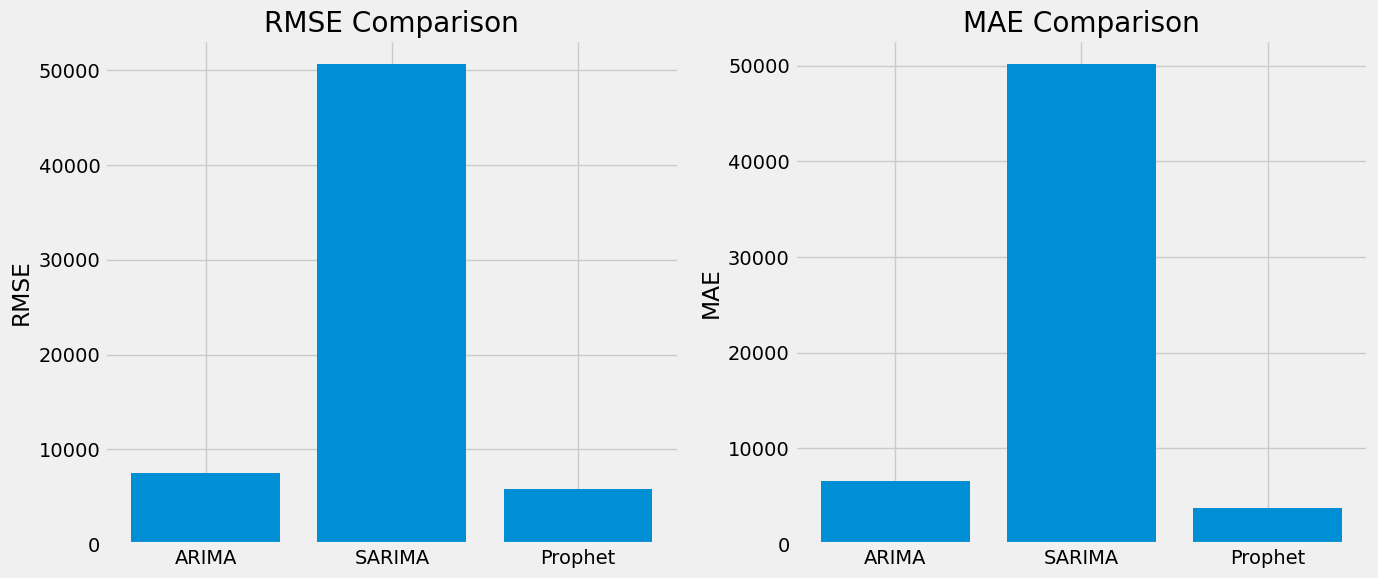

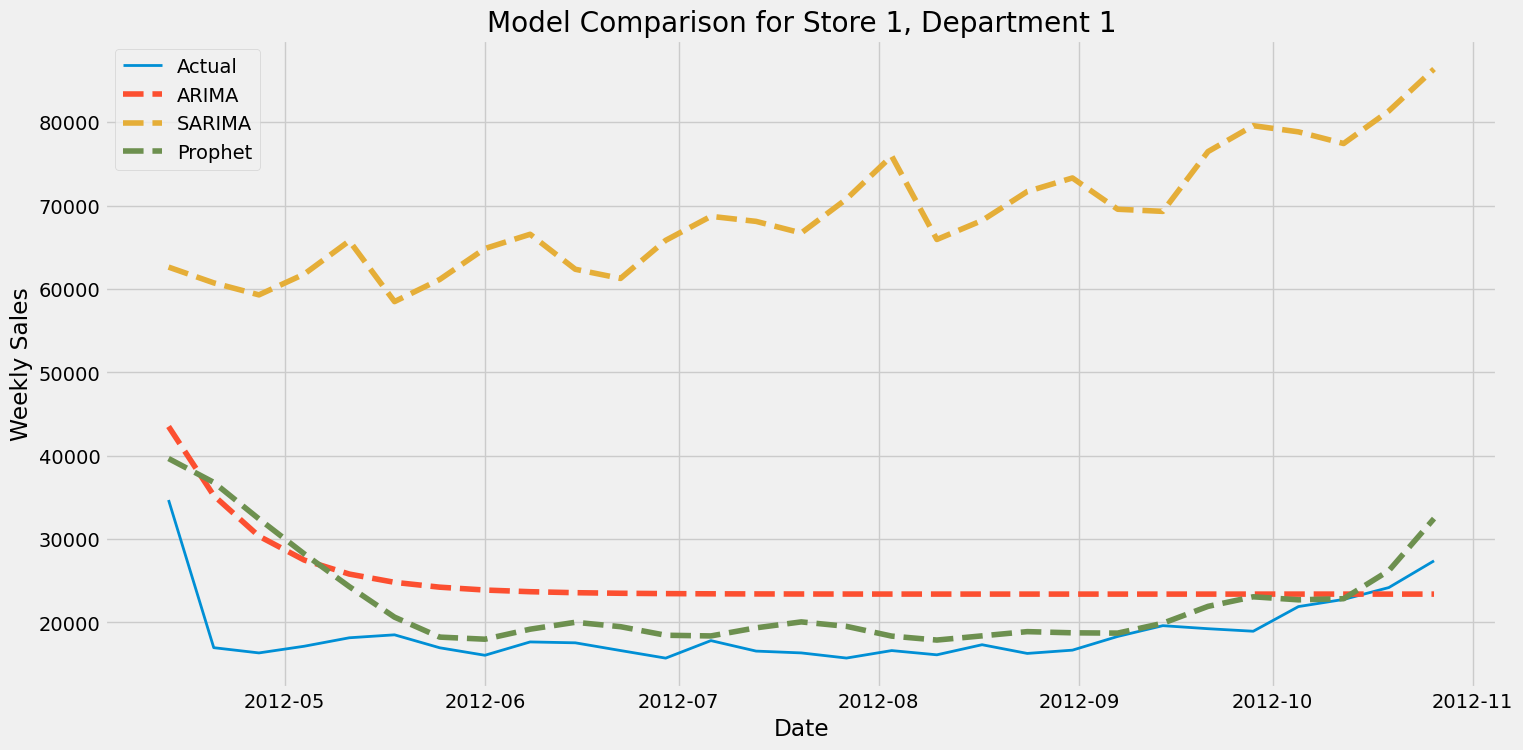

In [10]:
models = ['ARIMA', 'SARIMA', 'Prophet']
rmse_scores = [arima_rmse, sarima_rmse, prophet_rmse]
mae_scores = [arima_mae, sarima_mae, prophet_mae]

comparison_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'MAPE (%)': [arima_mape*100, sarima_mape*100, prophet_mape*100]
})

print("Model Performance Comparison:")
print(comparison_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.bar(models, rmse_scores)
ax1.set_title('RMSE Comparison')
ax1.set_ylabel('RMSE')

ax2.bar(models, mae_scores)
ax2.set_title('MAE Comparison')
ax2.set_ylabel('MAE')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(test_data_ts.index, test_data_ts, label='Actual', linewidth=2)
plt.plot(test_data_ts.index, arima_predictions, label='ARIMA', linestyle='--')
plt.plot(test_data_ts.index, sarima_predictions, label='SARIMA', linestyle='--')
plt.plot(test_data_ts.index, prophet_predictions, label='Prophet', linestyle='--')
plt.title(f'Model Comparison for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

23:58:28 - cmdstanpy - INFO - Chain [1] start processing
23:58:28 - cmdstanpy - INFO - Chain [1] done processing


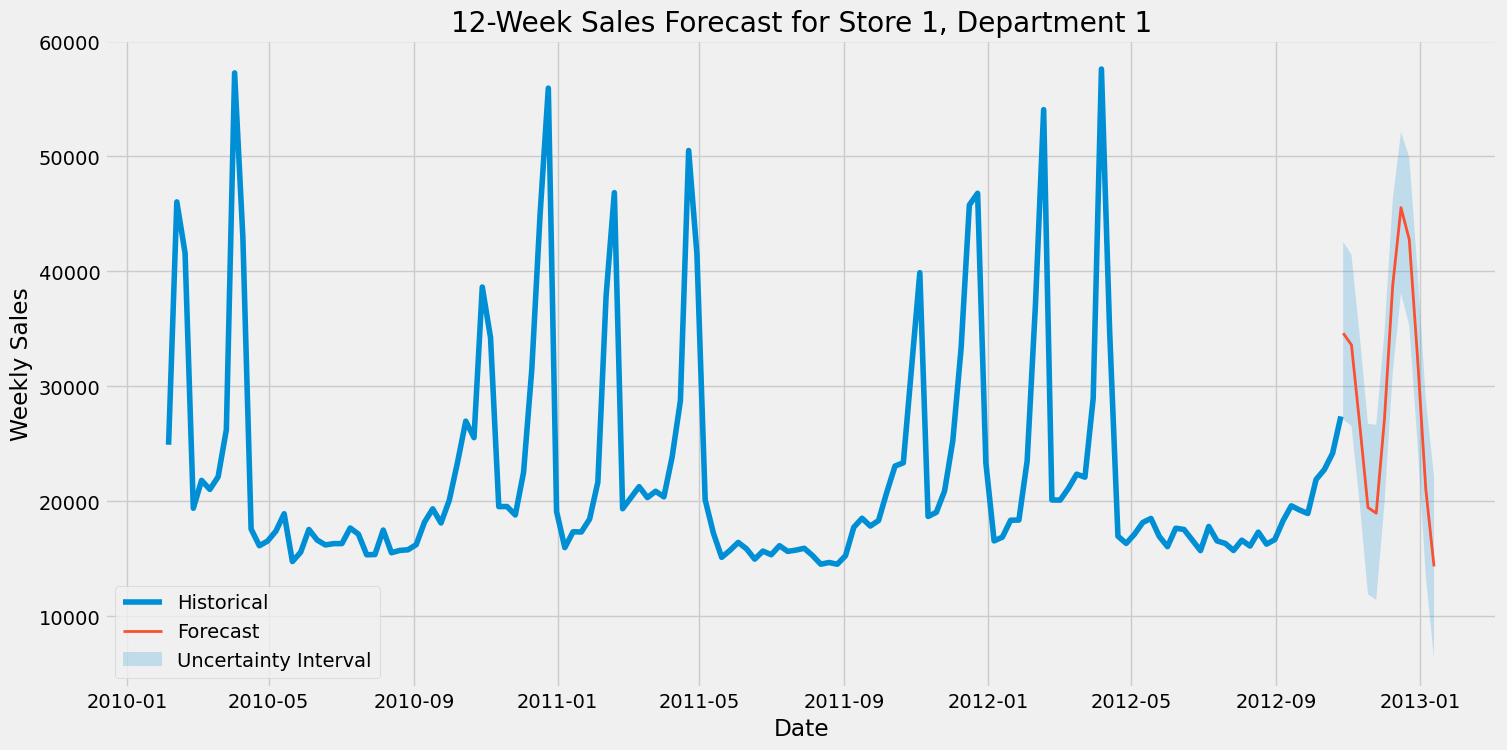

12-Week Forecast:
            ds          yhat    yhat_lower    yhat_upper
143 2012-10-28  34620.466761  27134.080250  42562.874093
144 2012-11-04  33605.794025  26558.945644  41462.693449
145 2012-11-11  26696.073667  19790.811091  34435.784801
146 2012-11-18  19469.181196  11916.481657  26753.710948
147 2012-11-25  18974.577782  11431.623353  26658.254274
148 2012-12-02  27188.687857  19823.145202  34709.908130
149 2012-12-09  38804.375739  31170.178823  46235.052990
150 2012-12-16  45540.702607  38099.691104  52120.404311
151 2012-12-23  42772.448151  35314.014067  49918.915379
152 2012-12-30  32530.004213  25046.219421  40114.548520
153 2013-01-06  21088.359981  13525.478808  28936.869828
154 2013-01-13  14349.664886   6373.978378  22134.782001


In [11]:
final_prophet_model = Prophet(holidays=holidays_df, yearly_seasonality=True, weekly_seasonality=True)
final_prophet_model.fit(prophet_data)

future = final_prophet_model.make_future_dataframe(periods=12, freq='W')

forecast = final_prophet_model.predict(future)

plt.figure(figsize=(16, 8))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical')
plt.plot(forecast['ds'].iloc[-12:], forecast['yhat'].iloc[-12:], label='Forecast', linewidth=2)
plt.fill_between(forecast['ds'].iloc[-12:], 
                 forecast['yhat_lower'].iloc[-12:], 
                 forecast['yhat_upper'].iloc[-12:], 
                 alpha=0.2, label='Uncertainty Interval')
plt.title(f'12-Week Sales Forecast for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

print("12-Week Forecast:")
future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)
print(future_forecast)